In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision
import torchaudio
from tqdm.notebook import trange

from pylibxai.utils import get_install_path

from captum.attr import IntegratedGradients, LRP
from captum.attr import visualization as viz
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
torch.cuda.is_available()

True

In [4]:
GTZAN_ROOT_DIR = str(get_install_path() / "pylibxai" / "datasets" / "GTZAN" / "Data")
SEED = 123
EPOCHS = 700
BATCH_SIZE = 128
LR = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
meta = pd.read_csv(f'{GTZAN_ROOT_DIR}/features_30_sec.csv')

In [6]:
meta

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [7]:
#len(dataset), len(meta)

In [8]:
GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [9]:
labels = {i: label for i, label in enumerate(meta.label.unique())}
label_to_id = {label: i for i, label in enumerate(meta.label.unique())}

In [10]:
labels

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [11]:
from torch.utils.data import Dataset
class GtzanDataset(Dataset):
    def __init__(self, metadata_file, gtzan_root, transform=None, sr=22050):
        self.metadata = pd.read_csv(metadata_file)
        self.audio_dir = os.path.join(gtzan_root, "genres_original")
        self.transform = transform
        self.sr = sr

    def __len__(self):
        return len(self.metadata)

    def pad_or_truncate_waveform(self, wav, target_len):
        current_len = wav.shape[-1]
        if current_len < target_len:
            pad_amt = target_len - current_len
            wav = F.pad(wav, (0, pad_amt))  # pad end with zeros
        elif current_len > target_len:
            wav = wav[:, :target_len]  # truncate
        return wav

    def __getitem__(self, idx):
        label = self.metadata.iloc[idx, -1]
        wav_path = os.path.join(self.audio_dir, label, self.metadata.iloc[idx, 0])
        label = label_to_id[self.metadata.iloc[idx, -1]]

        wav, _ = torchaudio.load(wav_path, normalize=True)
        wav = self.pad_or_truncate_waveform(wav, target_len=self.sr * 30)
            
        if self.transform:
            data = self.transform(wav)
        else:
            data = torch.from_numpy(wav).float()

        return data, label

In [12]:
transform = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=22050, 
                                         n_fft=1024, 
                                         f_min=0.0, 
                                         f_max=11025.0, 
                                         n_mels=128),
    torchaudio.transforms.AmplitudeToDB()
])

metadata = f"{GTZAN_ROOT_DIR}/features_30_sec_mod.csv"
dataset = GtzanDataset(metadata, GTZAN_ROOT_DIR, transform=transform)

In [13]:
len(dataset), len(pd.read_csv(metadata))

(999, 999)

In [14]:
from torch.utils.data import random_split
val_pc = 0.2

val_size = int(len(dataset)*val_pc)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(800, 199)

In [15]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
valid_loader = DataLoader(val_ds, batch_size, shuffle = False)

In [16]:
train_features, train_labels = next(iter(train_loader))

In [17]:
train_features.shape

torch.Size([64, 1, 128, 1292])

C:\Users\mfalk\AppData\Local\Temp\ipykernel_177048\1682399449.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  plt.imshow(spectrogram.T.numpy(), origin='lower', aspect='auto', cmap='magma')


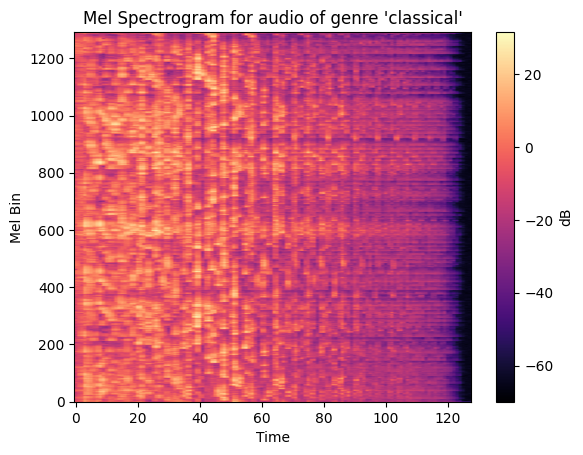

In [18]:
spectrogram = train_features[0]
label = labels[int(train_labels[0])]
plt.imshow(spectrogram.T.numpy(), origin='lower', aspect='auto', cmap='magma')
plt.title(f"Mel Spectrogram for audio of genre '{label}'")
plt.xlabel("Time")
plt.ylabel("Mel Bin")
plt.colorbar(label="dB")
plt.show()

In [19]:
class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

In [20]:
# Source: https://music-classification.github.io/tutorial/part3_supervised/tutorial.html#data-collection
class CNN(nn.Module):
    def __init__(self, num_channels=16,
                       num_classes=10):
        super(CNN, self).__init__()

        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3, 4))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 5))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 3))
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 4, pooling=(3, 4))

        # dense layers
        self.dense1 = nn.Linear(num_channels * 4, num_channels * 4)
        self.dense_bn = nn.BatchNorm1d(num_channels * 4)
        self.dense2 = nn.Linear(num_channels * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        out = self.input_bn(wav)

        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
valid_losses = []
EPOCHS = 30
progress = trange(EPOCHS, desc="Training")

def train():
    for epoch in progress:
        losses = []
    
        # Train
        cnn.train()
        for (wav, genre_index) in train_loader:
            wav = wav.to(device)
            genre_index = genre_index.to(device)
    
            # Forward
            out = cnn(wav)
            loss = loss_function(out, genre_index)
    
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, EPOCHS, np.mean(losses)))
    
        # Validation
        cnn.eval()
        y_true = []
        y_pred = []
        losses = []
        for wav, genre_index in valid_loader:
            wav = wav.to(device)
            genre_index = genre_index.to(device)
    
            # reshape and aggregate chunk-level predictions
            #print(f'{wav.shape}')
            #b, c, t = wav.size()
            #b, c, mel_bins, t = wav.size()
            logits = cnn(wav)
            #logits = logits.view(b, c, -1).mean(dim=1)
            loss = loss_function(logits, genre_index)
            losses.append(loss.item())
            _, pred = torch.max(logits.data, 1)
    
            # append labels and predictions
            y_true.extend(genre_index.tolist())
            y_pred.extend(pred.tolist())
        accuracy = accuracy_score(y_true, y_pred)
        valid_loss = np.mean(losses)
        print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, EPOCHS, valid_loss, accuracy))
    
        # Save model
        valid_losses.append(valid_loss.item())
        if np.argmin(valid_losses) == epoch:
            print('Saving the best model at %d epochs!' % epoch)
            torch.save(cnn.state_dict(), 'best_model.ckpt')

if not os.path.exists('best_model.ckpt'):
    train()
    torch.save(model.state_dict(), 'best_model.ckpt')
else:
    print('Model is already trained, skipping')
    S = torch.load('best_model.ckpt')
    cnn.load_state_dict(S)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Model is already trained, skipping


In [22]:
# Load the best model
S = torch.load('best_model.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in valid_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, mel_bins, t = wav.size()
        logits = cnn(wav)
        logits = logits.view(b, c, -1).mean(dim=1)
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

loaded!


Accuracy: 0.6834


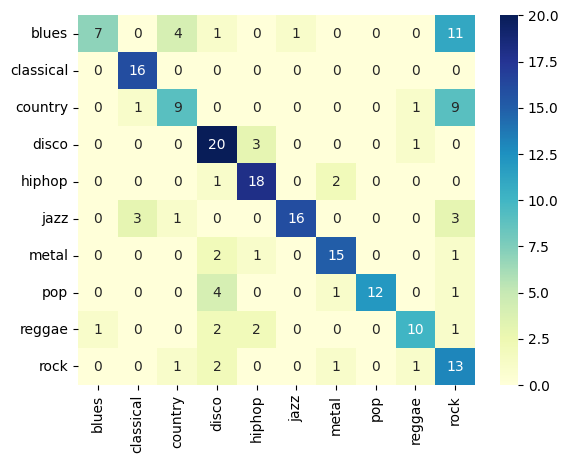

In [23]:
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)

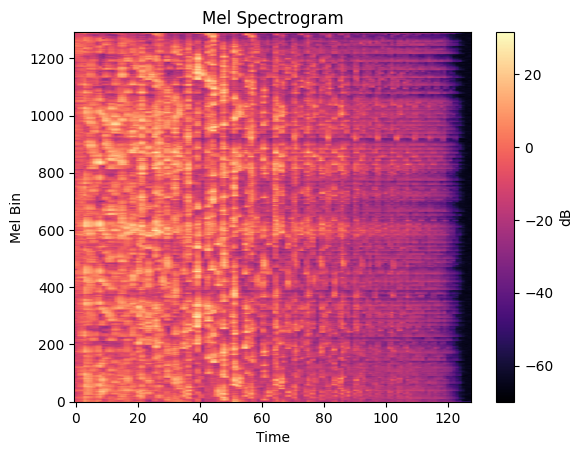

In [24]:
img = train_features[0]
plt.imshow(img.T.numpy(), origin='lower', aspect='auto', cmap='magma')
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Bin")
plt.colorbar(label="dB")
plt.show()

In [25]:
spectrogram, label = train_features[0], int(train_labels[0])

In [26]:
# Load one training sample
spectrogram, label = train_features[0], int(train_labels[0])
label_name = labels[label]

In [27]:
spectrogram.shape

torch.Size([1, 128, 1292])

In [28]:
# Prepare input shape: [1, 1, mel_bins, time]
if spectrogram.dim() == 2:
    spectrogram = spectrogram.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
elif spectrogram.dim() == 3:
    spectrogram = spectrogram.unsqueeze(0)  # [1, 1, H, W]
spectrogram = spectrogram.to(device)

In [29]:
spectrogram.shape

torch.Size([1, 1, 128, 1292])

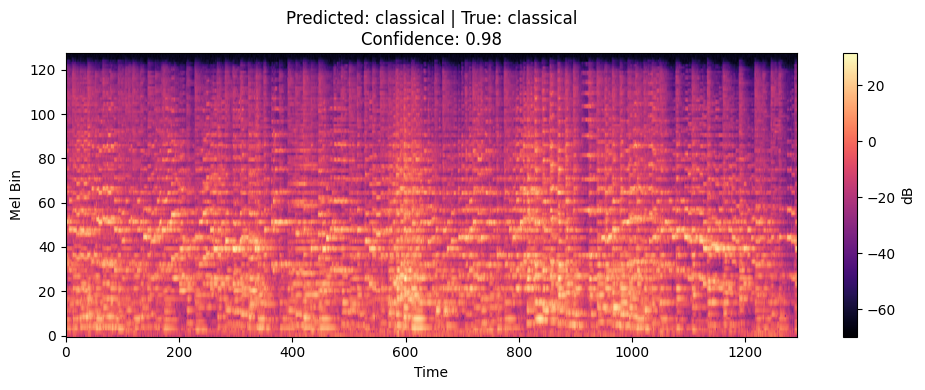

In [30]:
# Run inference
cnn.eval()
with torch.no_grad():
    logits = cnn(spectrogram)
    probs = F.softmax(logits, dim=1)
    top1_prob, top1_pred = torch.max(probs, dim=1)

# Decode prediction
predicted_class = list(label_to_id.keys())[top1_pred.item()]
confidence = top1_prob.item()

# Plot the spectrogram
img = spectrogram.squeeze().cpu()  # shape: [H, W]
plt.figure(figsize=(10, 4))
plt.imshow(img.numpy(), origin='lower', aspect='auto', cmap='magma')
plt.title(f"Predicted: {predicted_class} | True: {label_name}\nConfidence: {confidence:.2f}")
plt.xlabel("Time")
plt.ylabel("Mel Bin")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()

## Captum

In [31]:
import captum
from captum.attr import IntegratedGradients, LRP
from captum.attr import visualization as viz

In [32]:
cnn.eval()

CNN(
  (input_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv_2d(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layer2): Conv_2d(
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(3, 4), stride=(3, 4), padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layer3): Conv_2d(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [33]:
lrp = LRP(cnn)

In [34]:
spectrogram, label = train_features[0], int(train_labels[0])
spectrogram.shape, label

(torch.Size([1, 128, 1292]), 1)

In [35]:
spectrogram = spectrogram.unsqueeze(0).to(device)
spectrogram.requires_grad_(True)

tensor([[[[ -6.9600,  -3.8303,  -5.7479,  ..., -16.5535, -17.0592, -18.5040],
          [ -5.0823,  -4.6858,  -5.3602,  ...,  -0.8841,  -2.8650,  -4.4680],
          [ -3.0033,  -6.5446,  -4.6983,  ...,   3.3747,   1.3634,  -0.2434],
          ...,
          [-26.8407, -61.5817, -63.9280,  ..., -61.7533, -62.6569, -63.4078],
          [-26.9953, -65.3682, -61.9402,  ..., -67.1158, -66.2172, -64.9562],
          [-27.0593, -64.0767, -63.6348,  ..., -66.5725, -64.8408, -62.5494]]]],
       device='cuda:0', requires_grad=True)

In [36]:
attributions = lrp.attribute(spectrogram, target=label)

In [37]:
attributions = attributions.squeeze()
attributions.shape

torch.Size([128, 1292])

In [38]:
positive_attributions = torch.clamp(attributions, min=0.0)
summed_attributions = positive_attributions.sum(dim=0).detach().cpu().numpy()  # Shape: [1292]

In [39]:
attributions = attributions.squeeze().detach().cpu().numpy()
attributions = np.expand_dims(attributions, axis=0)  # shape: [1, H, W]
attributions = np.transpose(attributions, (1, 2, 0))  # shape: [H, W, 1]

In [40]:
attributions.shape

(128, 1292, 1)

In [41]:
attribution_norm = (attributions - attributions.min()) / (attributions.max() - attributions.min())

In [42]:
spectrogram = spectrogram.squeeze().detach().cpu().numpy()

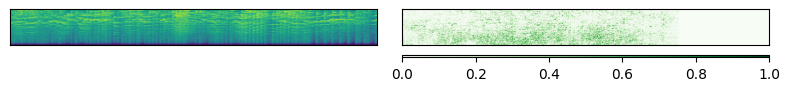

(<Figure size 800x600 with 4 Axes>, [<Axes: >, <Axes: >])

In [43]:
viz.visualize_image_attr_multiple(attributions,
                                  spectrogram,
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  show_colorbar=True,
                                  outlier_perc=50)

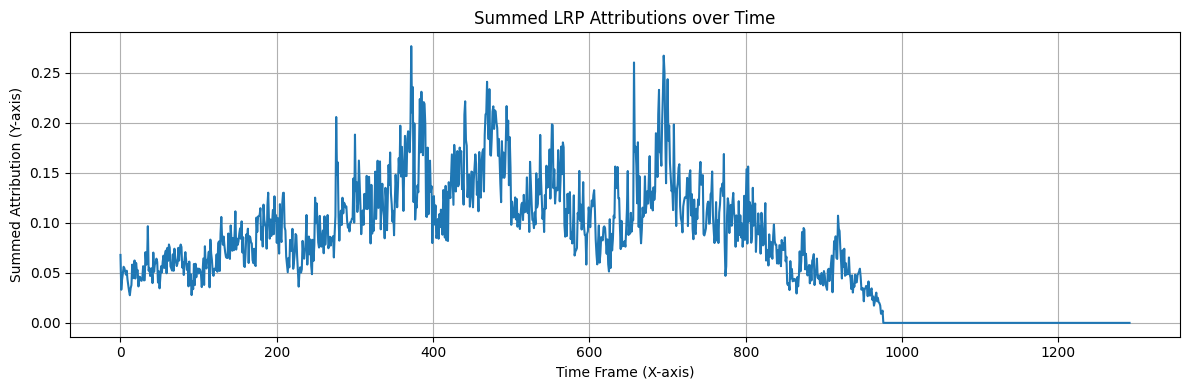

In [44]:
# Plot the summed attributions
plt.figure(figsize=(12, 4))
plt.plot(summed_attributions)
plt.title("Summed LRP Attributions over Time")
plt.xlabel("Time Frame (X-axis)")
plt.ylabel("Summed Attribution (Y-axis)")
plt.grid(True)
plt.tight_layout()
plt.savefig("lrp_summed_attributions.png")  # Save to file
plt.show()

In [45]:
ig = IntegratedGradients(cnn)

In [46]:
spectrogram, label = train_features[0], int(train_labels[0])
spectrogram = spectrogram.unsqueeze(0).to(device)
spectrogram.requires_grad_(True)

tensor([[[[ -6.9600,  -3.8303,  -5.7479,  ..., -16.5535, -17.0592, -18.5040],
          [ -5.0823,  -4.6858,  -5.3602,  ...,  -0.8841,  -2.8650,  -4.4680],
          [ -3.0033,  -6.5446,  -4.6983,  ...,   3.3747,   1.3634,  -0.2434],
          ...,
          [-26.8407, -61.5817, -63.9280,  ..., -61.7533, -62.6569, -63.4078],
          [-26.9953, -65.3682, -61.9402,  ..., -67.1158, -66.2172, -64.9562],
          [-27.0593, -64.0767, -63.6348,  ..., -66.5725, -64.8408, -62.5494]]]],
       device='cuda:0', requires_grad=True)

In [47]:
attributions, delta = ig.attribute(spectrogram, target=label, return_convergence_delta=True)

In [48]:
attributions = attributions.squeeze().detach().cpu().numpy()
attributions = np.expand_dims(attributions, axis=0)  # shape: [1, H, W]
attributions = np.transpose(attributions, (1, 2, 0))  # shape: [H, W, 1]

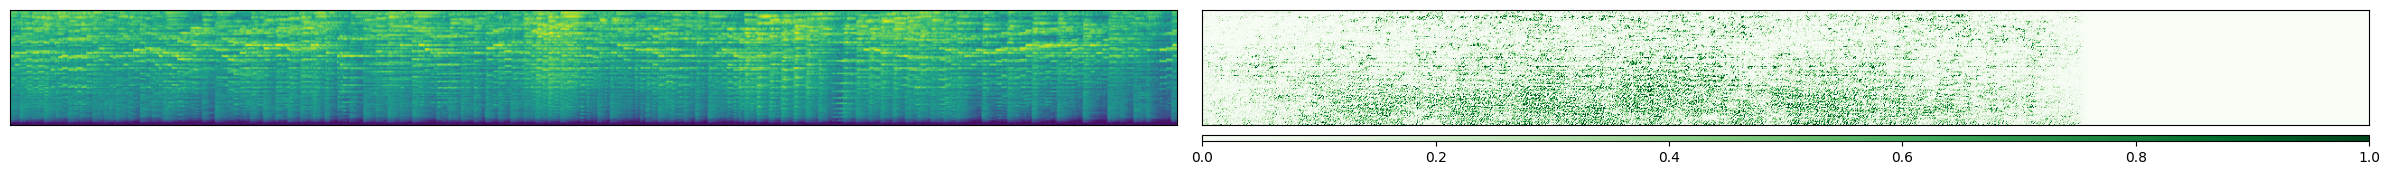

(<Figure size 2400x1600 with 4 Axes>, [<Axes: >, <Axes: >])

In [49]:
viz.visualize_image_attr_multiple(attributions,
                                  spectrogram.squeeze().detach().cpu().numpy(),
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  fig_size=(24,16),
                                  show_colorbar=True,
                                  outlier_perc=50)

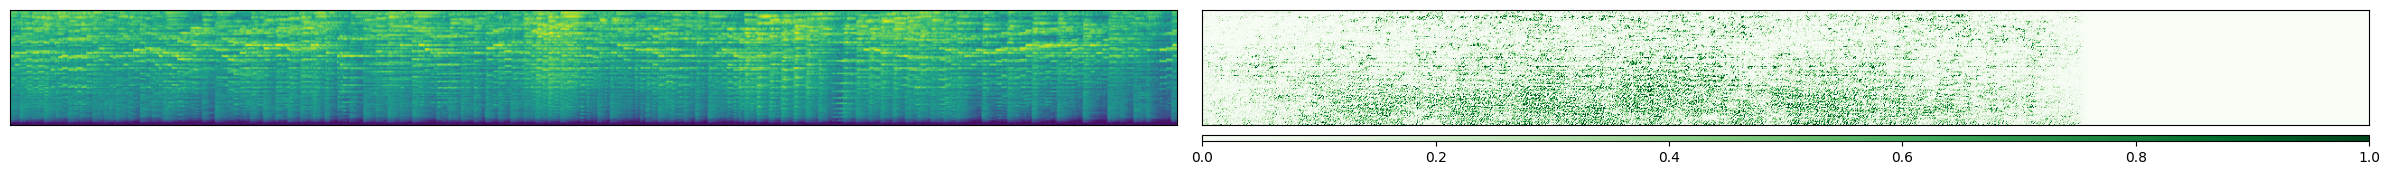

(<Figure size 2400x1600 with 4 Axes>, [<Axes: >, <Axes: >])

In [ ]:
viz.visualize_image_attr(attributions,
                                  spectrogram.squeeze().detach().cpu().numpy(),
                                  "original_image",
                                  "positive",
                                  fig_size=(24,16),
                                  show_colorbar=True,
                                  outlier_perc=50)

In [51]:
from pylibxai.models.GtzanCNN.preprocessing import convert_to_spectrogram

def write_spectrogram(self, audio, suffix):
    # convert audio to mel spectrogram in shape: [H, W]
    #img = audio.squeeze().cpu()
    audio = audio.squeeze().detach().cpu().numpy()
    print(f'audio squeezed detached: {audio.shape}')
    img = convert_to_spectrogram(audio, device='cpu')
    print(f'shape of img: {img.shape}')
    plt.figure(figsize=(10, 4))
    plt.imshow(img.numpy(), origin='lower', aspect='auto', cmap='magma')
    plt.xlabel("Time")
    plt.ylabel("Mel Bin")
    plt.colorbar(label="dB")
    plt.tight_layout()
    plt.savefig(os.path.join(self.workdir, suffix), bbox_inches='tight')
    plt.close()

In [52]:
from utils import get_install_path

audio, _ = torchaudio.load(get_install_path() / 'datasets/GTZAN/Data/genres_original/jazz/jazz.00050.wav', normalize=True)

ModuleNotFoundError: No module named 'utils'